# Выполнил:
# Радайкин Артём, ПМ20-4 

## Загружаем данные

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy as pt
import sklearn.linear_model as lm
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Эконометрика /Данные_7.xlsx')
df.head(5)

,Y,X1,X2,X3
0,15.3,135.2,109.5,125.2
1,18.6,86.5,111.4,112.2
2,19.4,107.4,105.3,105.1
3,18.1,108.1,105.1,112.4
4,19.9,104.6,112.0,106.2


In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('Y ~ X1+X2+X3', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,1163.073118,Intercept
1,1.137075,X1
2,1.147613,X2
3,1.035222,X3


## Вывод: Так как все VIF значения меньше 10, то можно сделать вывод, что построенная модель yt = ... не содкржит коллинеарных факторов и может быть использована для анализа и прогнозирования 

### Построим модель:

In [ ]:
X1 = df['X1'].values
X2 = df['X2'].values
X3 = df['X3'].values
Y = df['Y'].values

In [ ]:
model = sm.OLS.from_formula("Y ~ X1 + X2 + X3", data=df)
result = model.fit()
print(result.params)

Intercept    69.532016
X1           -0.074919
X2           -0.349244
X3           -0.049191
dtype: float64


In [ ]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     9.294
Date:                Sat, 10 Dec 2022   Prob (F-statistic):            0.00123
Time:                        12:53:51   Log-Likelihood:                -29.069
No. Observations:                  18   AIC:                             66.14
Df Residuals:                      14   BIC:                             69.70
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     69.5320     11.088      6.271      0.0

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
t_tabl = sts.t.isf(0.05/2, 14)
t_tabl

2.1447866879169277

In [ ]:
f_tabl = sts.f.isf(0.05, 3, 14)
f_tabl

3.3438886781189123

# Алгоритм проверки 



### Построим корреляционную матрицу между экзогенными перемеными

In [ ]:
corr_matrix = df.drop('Y', axis=1).corr()
det = np.linalg.det(corr_matrix)
det

0.865116163185151

### Вычислим наблюдаемре значение статистики Фаррара-Глоубера:

In [ ]:
n = 18
k = 3
FG = -(n-1-(1/6)*(2*k+5))*np.log(det)
FG

2.197520906901297

In [ ]:
chi2_tabl = sts.chi2.isf(0.05, (1/2)*k*(k-1))
chi2_tabl

7.814727903251178

## Вывод: Т.к. FG =< chi2_tabl (2.197520906901297 < 7.814727903251178), то гипотеза H0 отвергается => мультиколлинеарность отсутствует 

## Найдём обратную матрицу корреляционной матрицы

In [ ]:
inv_matrix = np.linalg.inv(corr_matrix)

array([[ 1.1370754 ,  0.38601575, -0.14564043],
       [ 0.38601575,  1.14761281, -0.1792197 ],
       [-0.14564043, -0.1792197 ,  1.03522183]])

### Возьмём главную диагональ:

In [ ]:
diag = np.diagonal(inv_matrix)
diag

array([1.1370754 , 1.14761281, 1.03522183])

### Вычислим F-критерий для каждого фактора:

In [ ]:
F_4fact = (diag - 1)*(n - k - 1) / k
F_4fact

array([0.63968518, 0.6888598 , 0.16436852])

In [ ]:
sts.f.isf(0.05, 3, 14)

3.3438886781189123

In [ ]:
F_4fact < sts.f.isf(0.05, 3, 14)

array([ True,  True,  True])

## Вывод: Сравниваем с табличными значениями, и получаем что F-набл каждого фактора < F_табл => H0 отвергается => мультиколлинеарность отсутсвует 

# Каждой пары переменных (t-тест)

## Найдём частные коэффициенты корреляции

In [ ]:
inv_matrix

array([[ 1.1370754 ,  0.38601575, -0.14564043],
       [ 0.38601575,  1.14761281, -0.1792197 ],
       [-0.14564043, -0.1792197 ,  1.03522183]])

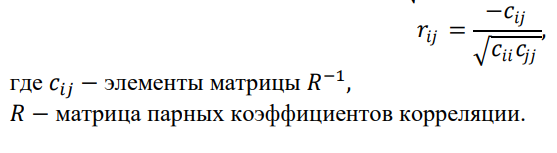

In [ ]:
r_coefs = []
for i in range(3):
  for j in range(3):
    r_coefs.append(-inv_matrix[i,j] / np.sqrt(inv_matrix[i,i] * inv_matrix[j,j]))
r_coefs = np.array(r_coefs)

In [ ]:
r_coefs = r_coefs.reshape(3,3)
r_coefs

array([[-1.        , -0.33791907,  0.13423649],
       [-0.33791907, -1.        ,  0.16442632],
       [ 0.13423649,  0.16442632, -1.        ]])

### Вычислим t-критерий 

In [ ]:
t_obs = []
for r in [r_coefs[0,1], r_coefs[0,2], r_coefs[1,2]]:
    t_obs.append(r * np.sqrt(n - k - 1) / np.sqrt(1 - r**2))
t_obs

[-1.3434028336189843, 0.5068543411836797, 0.623716118670544]

In [ ]:
t_tabl = sts.t.isf(0.05/2, 14)
t_tabl

2.1447866879169277

In [ ]:
t_tabl > t_obs

array([ True,  True,  True])

# Вывод: Сравниваем с табличными значениями, и получаем что t-набл каждого фактора < t_табл => H0 отвергается => мультиколлинеарность отсутсвует